In [229]:
import math
from functools import reduce
from itertools import compress
import operator

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = 10000  # Set the row limit for returned data

In [245]:
object_name = "NGC 663"
#object_name = "M31"
object_name = "NGC 118"

In [246]:
obj_center = SkyCoord.from_name(object_name)

In [247]:
job = Gaia.cone_search_async(obj_center, radius=60.0*u.arcmin)  # 2 deg FOV
obj_data = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [248]:
obj_data_p = obj_data[obj_data['parallax'] > 0]
obj_data_p = obj_data_p[reduce(operator.and_, [~obj_data_p['parallax'].mask, ~obj_data_p['phot_g_mean_mag'].mask, ~obj_data_p['bp_rp'].mask, ~obj_data_p['e_bp_min_rp_val'].mask, ~obj_data_p['a_g_val'].mask])]  # remove masked cr*p
obj_table_bprp = (obj_data_p['bp_rp'] - obj_data_p['e_bp_min_rp_val'])  # adj for reddenning
obj_table_mag = obj_data_p['phot_g_mean_mag'] - obj_data_p['a_g_val'] + 5 * np.log10(obj_data_p['parallax']) - 10  # adj for extinction
min_mag, max_mag = (min(obj_table_mag), max(obj_table_mag))
min_br, max_br = (min(obj_table_bprp), max(obj_table_bprp))

In [249]:
def bv2rgb(bv):
    # https://stackoverflow.com/questions/21977786/star-b-v-color-index-to-apparent-rgb-color
    # b-v, b-r, potatos, tomatoes... but it will do for now
    if bv < -0.40: bv = -0.40
    if bv > 2.00: bv = 2.00
    r, g, b = (0.0, 0.0, 0.0)
    if  -0.40 <= bv<0.00:
        t=(bv+0.40)/(0.00+0.40)
        r=0.61+(0.11*t)+(0.1*t*t)
    elif 0.00 <= bv<0.40:
        t=(bv-0.00)/(0.40-0.00)
        r=0.83+(0.17*t)
    elif 0.40 <= bv<2.10:
        t=(bv-0.40)/(2.10-0.40)
        r=1.00
    if  -0.40 <= bv<0.00:
        t=(bv+0.40)/(0.00+0.40)
        g=0.70+(0.07*t)+(0.1*t*t)
    elif 0.00 <= bv<0.40:
        t=(bv-0.00)/(0.40-0.00)
        g=0.87+(0.11*t)
    elif 0.40 <= bv<1.60:
        t=(bv-0.40)/(1.60-0.40)
        g=0.98-(0.16*t)
    elif 1.60 <= bv<2.00:
        t=(bv-1.60)/(2.00-1.60)
        g=0.82-(0.5*t*t)
    if  -0.40 <= bv<0.40:
        t=(bv+0.40)/(0.40+0.40)
        b=1.00
    elif 0.40 <= bv<1.50:
        t=(bv-0.40)/(1.50-0.40)
        b=1.00-(0.47*t)+(0.1*t*t)
    elif 1.50 <= bv<1.94:
        t=(bv-1.50)/(1.94-1.50)
        b=0.63-(0.6*t*t)
    return (r, g, b)
def bv2t(bv):  # bv, br ... etc
    return 4600.0*(1/(0.92*bv+1.7)+1/(0.92*bv+0.62))
def t2bv(T):
    return 1/46 * (-58 + math.sqrt(729 + 52900000000/T**2) + 230000/T)
def absM(R, bv):
    r = R * 6.95508e8
    return 4.76-2.5*math.log10((4*math.pi*5.6704e-8*r*r*bv2t(bv)**4)/3.839e26)

In [250]:
cols = [bv2rgb(c) for c in obj_table_bprp]

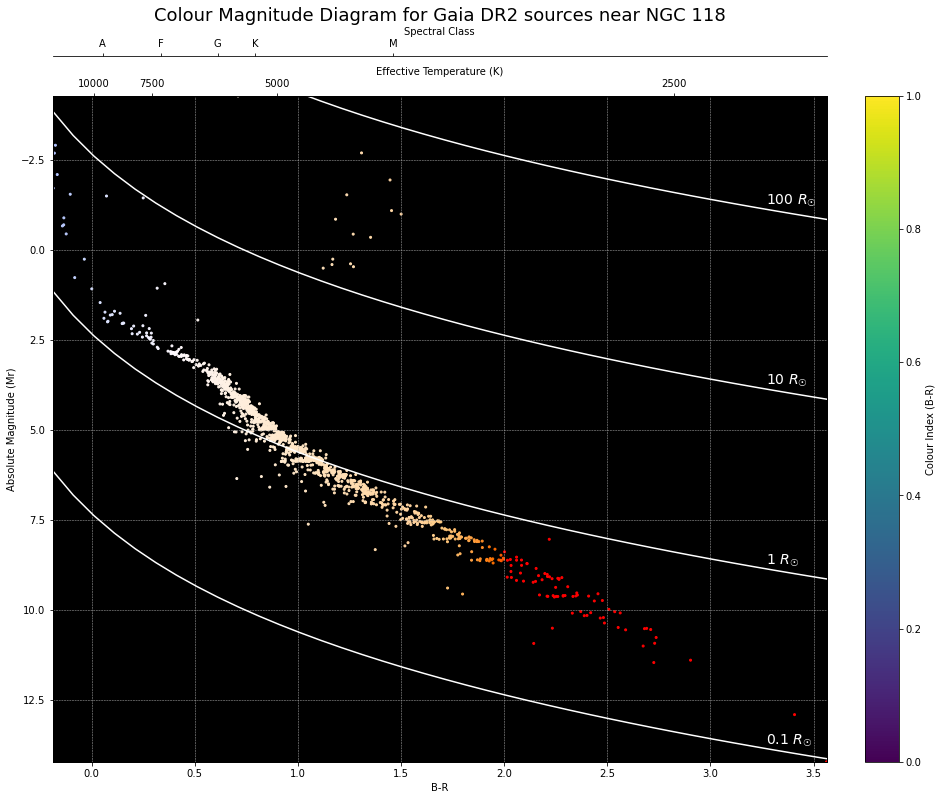

In [251]:
fig, ax = plt.subplots(figsize=(13, 11), constrained_layout=True)
cs = ax.scatter(obj_table_bprp, 
                obj_table_mag, 
                c=cols, s=4)
ax.set_facecolor('xkcd:black')
cb = fig.colorbar(cs)
cb.set_label(f'Colour Index (B-R)')

ax.set_xlim((min_br, max_br))
ax.set_ylim((min_mag, max_mag))
ax2 = ax.twiny()
ax3 = ax.twiny()
ax.invert_yaxis()

ax.set_xlabel('B-R')
ax.set_ylabel('Absolute Magnitude (Mr)')
ax.set_title('Colour Magnitude Diagram for Gaia DR2 sources near '+object_name, fontsize=18)
ax.grid(linestyle='--', linewidth=0.5)

# Teff axis
ax2.set_xlabel('Effective Temperature (K)')
#ax2.set_xlim((bv2t(min_br), bv2t(max_br)))
spectral_labs = [60_000, 30_000,  10_000, 7_500, 5_000, 2_500, 1_000]
spectral_tics = list(map(t2bv, spectral_labs))
sl_mask = [s >= min_br and s <= max_br for s in spectral_tics]
spectral_labs = list(compress(spectral_labs, sl_mask))
spectral_tics = list(compress(spectral_tics, sl_mask))
ax2.set_xlim((min_br, max_br))
ax2.xaxis.set_major_locator(mticker.FixedLocator(spectral_tics))
ax2.xaxis.set_major_formatter(mticker.FixedFormatter(spectral_labs))

# Spectral class axis
ax3.set_xlabel('Spectral Class')
spectral_labs = ['O', 'B',  'A', 'F', 'G', 'K', 'M']
spectral_tics = [t2bv(41_100), t2bv(31_000), t2bv(9_500), t2bv(7_240), t2bv(5_920), t2bv(5_300), t2bv(3_850)]
sl_mask = [s >= min_br and s <= max_br for s in spectral_tics]
spectral_labs = list(compress(spectral_labs, sl_mask))
spectral_tics = list(compress(spectral_tics, sl_mask))
ax3.set_xlim((min_br, max_br))
ax3.xaxis.set_major_locator(mticker.FixedLocator(spectral_tics))
ax3.xaxis.set_major_formatter(mticker.FixedFormatter(spectral_labs))
ax3.spines['top'].set_position(('axes', 1.06))

# add constant radius lines
xx = np.arange(min_br-1,max_br+1,0.1)
label_x = max_br-(max_br-min_br)/9
label_dx = (max_br-min_br)/30
label_c = 'white'
label_fs = 14
ax.text(label_x+label_dx, absM(0.1, label_x), "0.1 $R_☉$", color=label_c, fontsize=label_fs)
yy = [absM(0.1, x) for x in xx]
ax.plot(xx, yy, color=label_c)  # .1 sun
ax.text(label_x+label_dx, absM(1, label_x), "1 $R_☉$", color=label_c, fontsize=label_fs)
yy = [absM(1, x) for x in xx]
ax.plot(xx, yy, color=label_c)  # .1 sun
ax.text(label_x+label_dx, absM(10, label_x), "10 $R_☉$", color=label_c, fontsize=label_fs)
yy = [absM(10, x) for x in xx]
ax.plot(xx, yy, color=label_c)  # .1 sun
ax.text(label_x+label_dx, absM(100, label_x), "100 $R_☉$", color=label_c, fontsize=label_fs)
yy = [absM(100, x) for x in xx]
ax.plot(xx, yy, color=label_c)  # .1 sun
ax.text(label_x+label_dx, absM(1000, label_x), "1000 $R_☉$", color=label_c, fontsize=label_fs)
yy = [absM(1000, x) for x in xx]
ax.plot(xx, yy, color=label_c)  # .1 sun